### ANALISIS EXPLORATORIO



In [191]:
#from google.colab import drive
#drive.mount('/content/drive')

In [287]:
#librerias
import pandas as pd
import matplotlib.pyplot as plot
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import numpy as np
from datetime import date, datetime, timedelta
from os import name

Definición de parámetros iniciales

In [193]:
NUM_OF_WEEK = 8.0
HOURS_OF_DAY = 24
DAYS_OF_WEEK = 7
FORMAT_DATE = '%Y-%m-%d'
DATE_START_TRAINIG = pd.to_datetime("2022-04-13", format=FORMAT_DATE)
FICHERO_DATA = './data/SERVICIO_UNIFICADO_2022.parquet.gzip'

In [194]:
#Se lee el archivo de un parquet a un dataframe
df = pd.read_parquet(FICHERO_DATA) 

print("Dataset cargado con éxito")

Dataset cargado con éxito


Se valida cuantos valores nulos tenemos en el dataset

In [195]:
#Contar cuantos datos se encuentran nulos
df.isnull().sum()

ID                       0
IDCIUDAD                 0
USUARIO               1707
TELEFONOORIGEN       69322
LATITUD                  0
LATITUDDESTINO     1932690
LONGITUD                 0
LONGITUDDESTINO    1932690
ESTADO                   0
ORIGEN                   0
FECHACOMPLETA            0
DIADESEMANA              0
HORA                     0
dtype: int64

Se limpian los datos donde el teléfono del usuario es nulo
 para tener usuarios validos y limitamos los datos de bogotá

In [196]:
df.head(5)

,ID,IDCIUDAD,USUARIO,TELEFONOORIGEN,LATITUD,LATITUDDESTINO,LONGITUD,LONGITUDDESTINO,ESTADO,ORIGEN,FECHACOMPLETA,DIADESEMANA,HORA
0,70152580,11001,8946882.0,3186429637,4.642036,4.630580,-74.187636,-74.189880,CANCELADO,APP,2022-04-30 19:00:00,7,19
1,70152581,11001,9665930.0,3209171095,4.594340,4.604060,-74.138168,-74.141610,ABANDONADO,APP,2022-04-30 19:00:00,7,19
2,70152582,76001,9243481.0,3147558713,3.367783,NaN,-76.531083,NaN,ABANDONADO,APP,2022-04-30 19:00:01,7,19
3,70152583,11001,841805.0,3125733084,4.630927,NaN,-74.092728,NaN,ABANDONADO,CHAT_BOT_659,2022-04-30 19:00:01,7,19
4,70152584,11001,9330612.0,3043963812,4.548637,4.622711,-74.096414,-74.147018,ABANDONADO,APP,2022-04-30 19:00:01,7,19


In [197]:
#Eliminamos los registros nulos del telefono de origen
df = df[~df['TELEFONOORIGEN'].isnull()]
#Filtramos para ciudad de bogotá
df = df[df["IDCIUDAD"]==11001]

Limitamos los canales por donde se reciben servicios a APP, IVR, CHATBOT, RECEPCIÓN, CALLE Y WEB que son los más relevantes.
Limitamos los estados a ABANDONADO, CUMPLIDO, CANCELADO Y FINALIZADO que son los validos, el restos son errores del proceso.

In [198]:
df = df[(df["ORIGEN"]=="APP") | (df["ORIGEN"]=="IVR") | (df["ORIGEN"]=="CHAT_BOT_659") | (df["ORIGEN"]=="RECEPCION") | (df["ORIGEN"]=="CALLE") | (df["ORIGEN"]=="WEB")]
df = df[(df["ESTADO"]=="ABANDONADO") | (df["ESTADO"]=="CUMPLIDO") | (df["ESTADO"]=="CANCELADO") | (df["ESTADO"]=="FINALIZADO")]

Eliminamos las columnas de ciudad, usuario, id servicio, latitud y longitud de destino

In [199]:
#Se definen las fechas y el día de la semana
df['FECHACOMPLETA'] = pd.to_datetime(df['FECHACOMPLETA'], format='%Y/%m/%d %H:%M:%S')
df['FECHA'] = df['FECHACOMPLETA'].dt.strftime(FORMAT_DATE)
df['DIADESEMANA'] = df['FECHACOMPLETA'].map( lambda x: x.isoweekday() )
df.head(5)

,ID,IDCIUDAD,USUARIO,TELEFONOORIGEN,LATITUD,LATITUDDESTINO,LONGITUD,LONGITUDDESTINO,ESTADO,ORIGEN,FECHACOMPLETA,DIADESEMANA,HORA,FECHA
0,70152580,11001,8946882.0,3186429637,4.642036,4.630580,-74.187636,-74.189880,CANCELADO,APP,2022-04-30 19:00:00,6,19,2022-04-30
1,70152581,11001,9665930.0,3209171095,4.594340,4.604060,-74.138168,-74.141610,ABANDONADO,APP,2022-04-30 19:00:00,6,19,2022-04-30
3,70152583,11001,841805.0,3125733084,4.630927,NaN,-74.092728,NaN,ABANDONADO,CHAT_BOT_659,2022-04-30 19:00:01,6,19,2022-04-30
4,70152584,11001,9330612.0,3043963812,4.548637,4.622711,-74.096414,-74.147018,ABANDONADO,APP,2022-04-30 19:00:01,6,19,2022-04-30
5,70152585,11001,8303036.0,3113623140,4.723984,4.743134,-74.054207,-74.090683,ABANDONADO,APP,2022-04-30 19:00:02,6,19,2022-04-30


In [200]:
#Eliminamos las columan que no son útiles en el modelo
df = df.drop(columns=["IDCIUDAD","USUARIO","ID","LATITUDDESTINO","LONGITUDDESTINO","LATITUD","LONGITUD","FECHACOMPLETA","ORIGEN","ESTADO"])

#Se eliminan los duplicados
df = df.drop_duplicates().sort_values(by=['TELEFONOORIGEN','FECHA','DIADESEMANA','HORA'])
df = df.reset_index(drop=True)
count_data = df.loc[:,['TELEFONOORIGEN']].value_counts()
count_data

TELEFONOORIGEN
3107584482        783
3138647901        684
3153865158        684
3134579964        642
13148180          628
                 ... 
3125329815          1
3125330004          1
3125330436          1
3125330453          1
999883673           1
Length: 517850, dtype: int64

In [201]:
data = df.copy()




#Se filtran tomando últimas x semanas de la fecha inicial de entrenamiento
date_last_training = DATE_START_TRAINIG - timedelta(weeks=NUM_OF_WEEK)
data = data[ pd.to_datetime(data['FECHA'], format=FORMAT_DATE) > date_last_training ]


#Se descartan los que tienen menos de 10 solicitudes en ese tiempo
data = data.groupby('TELEFONOORIGEN').filter(lambda x: x['TELEFONOORIGEN'].count() > 10)

#df_train = data[ (pd.to_datetime(data['FECHA'], format=FORMAT_DATE) < DATE_START_TRAINIG) & (pd.to_datetime(data['FECHA'], format=FORMAT_DATE) > date_last_training) ]
#df_train = df_train.groupby('TELEFONOORIGEN').filter(lambda x: x['TELEFONOORIGEN'].count() > 1)

#df_test = data[pd.to_datetime(data['FECHA'], format=FORMAT_DATE) >= DATE_START_TRAINIG ]



count_data = data.loc[:,['TELEFONOORIGEN']].value_counts()
count_data

TELEFONOORIGEN
3107584482        564
3153865158        525
3134579964        487
3138647901        485
3002035444        465
                 ... 
3118330587         11
3028348251         11
3118353998         11
3118355887         11
3202755797         11
Length: 60374, dtype: int64

Transformamos el valor de origen y estado a no ordinales con onehot.

In [202]:
# convertimos a  onehot la comuna de origen
#df = pd.get_dummies(df, columns=["ORIGEN"])
# convertimos a  onehot la comuna de estado
#df = pd.get_dummies(df, columns=["ESTADO"])
"""new_df['ORIGEN'] = new_df['ORIGEN'].map( {
        "APP":1,
        "CALLE":2,
        "CHAT_BOT_659":3,
        "CHAT_BOT_689":4,
        "CHAT_BOT_729":5,
        "CHAT_BOT_803":6,
        "EXTERNO":7,
        "IONTAXI":8,
        "IVR":9,
        "NUEVO":10,
        "RECEPCION":11,
        "RED AMARILLA":12,
        "Reserva":13,
        "TELEGRAMTD":14,
        "WEB":15
    } )

new_df['ESTADO'] = new_df['ESTADO'].map( {
        "ABANDONADO":1,
        "ABORDOCONFIRMADO":2,
        "ALFRENTE":3,
        "ASIGNADO": 4,
        "CANCELADO":5,
        "CONFIRMADO":6,
        "CUMPLIDO":7,
        "FINALIZADO": 8,
        "LOCUCION":9,
        "NUEVO":10,
        "RECHAZADO":11
    } )"""
data.head(5)

,TELEFONOORIGEN,DIADESEMANA,HORA,FECHA
248,0000000000,4,3,2022-02-17
249,0000000000,4,6,2022-02-17
250,0000000000,4,15,2022-02-17
251,0000000000,5,6,2022-02-18
252,0000000000,5,8,2022-02-18


In [203]:
#Se crea un nuevo dataframe con los teléfonos para entrenar cada usuario personalizado
data_phone = data.loc[:,['TELEFONOORIGEN']].copy()
data_phone = data_phone.drop_duplicates().sort_values(by=['TELEFONOORIGEN'])
data_phone = data_phone.reset_index(drop=True)
data_phone.head()

,TELEFONOORIGEN
0,0000000000
1,12001086
2,12003951
3,12009954
4,12011349


In [204]:
def findRow(pdate, phour, data):
  for row in data:
    if( ( row[3] == pdate.strftime(FORMAT_DATE) ) & ( row[2] == phour ) ):
      return row
  return []


In [205]:
#Funcion para llenar los servicios no tomados con 0
def preparingDataService(data, from_date, to_date, phone):
  #first = pd.to_datetime(data.tail(1).iloc[0,3], format=FORMAT_DATE)
  #last = pd.to_datetime(data.head(1).iloc[0,3], format=FORMAT_DATE)
  
  first = to_date
  last = from_date

  remaining_days = first.date() - last.date()
  data_array = data.to_numpy()
  new_array = []
  for i in range(remaining_days.days+1):
    last_time = last + timedelta(days=i)
    for day in range(HOURS_OF_DAY):
      new_row = findRow(last_time.date(), day, data_array)
      if len(new_row) > 0:
        new_array.append(np.append(new_row, 1))
      else:
        new_array.append([phone, last_time.isoweekday(),day,last_time.date().strftime(FORMAT_DATE),0])
  #col = data.columns
  #print(type(col))
  #for col in data.columns:
  #  print(col)
  return pd.DataFrame(new_array, 
             columns=['TELEFONOORIGEN', 
                      'DIADESEMANA', 'HORA','FECHA','SERVICIO'])

In [206]:
def calculateProbability(hour, day, data):
  data_array = data.to_numpy()

  first = pd.to_datetime(data.tail(1).iloc[0,3], format=FORMAT_DATE)
  last = pd.to_datetime(data.head(1).iloc[0,3], format=FORMAT_DATE)
  remaining_days = first.date() - last.date()
  #print("First:",first,", last:",last,", remaining:",remaining_days)
  total = 0 
  for i in range(remaining_days.days):
    last_time = last + timedelta(days=i)
    if last_time.isoweekday() == day:
      total += 1
  
  total_onset = 0
  for row in data_array:
    if( ( row[1] == day ) & ( row[2] == hour ) & ( row[4] == 1 ) ):
      total_onset += 1
  
  #print("Total:",total,",Total onset:",total_onset)
  if total > 0:
    return total_onset / total
  else:
    return 0

In [207]:
'''def calculateProbabilisticModel(dataFrame):
  array_date_of_week = []
  for day in range(DAYS_OF_WEEK):
    array_hours = []
    for hour in range(HOURS_OF_DAY):
      array_hours.append( calculateProbability(hour, day+1, dataFrame))
    array_date_of_week.append(array_hours)
  return pd.DataFrame(np.array(array_date_of_week),
                    columns=[h for h in range(HOURS_OF_DAY)], index=["1-Monday","2-Tuesday","3-Wednesday","4-Thursday","5-Friday","6-Saturday","7-Sunday"],).transpose()'''

'def calculateProbabilisticModel(dataFrame):\n  array_date_of_week = []\n  for day in range(DAYS_OF_WEEK):\n    array_hours = []\n    for hour in range(HOURS_OF_DAY):\n      array_hours.append( calculateProbability(hour, day+1, dataFrame))\n    array_date_of_week.append(array_hours)\n  return pd.DataFrame(np.array(array_date_of_week),\n                    columns=[h for h in range(HOURS_OF_DAY)], index=["1-Monday","2-Tuesday","3-Wednesday","4-Thursday","5-Friday","6-Saturday","7-Sunday"],).transpose()'

In [208]:
#def evaluation( model, data_frame ):
#Se filtran tomando solo las últimas x semanas

    
    #evaluation(data_row, "PROBABILISTIC", data, FROM_DATE_TEST, NUM_OF_WEEK)

In [209]:
data_us = data[data["TELEFONOORIGEN"]=="3115590650"]
data_us.tail(100)

,TELEFONOORIGEN,DIADESEMANA,HORA,FECHA
1418432,3115590650,5,17,2022-04-29
1418433,3115590650,5,18,2022-04-29
1418434,3115590650,5,19,2022-04-29
1418435,3115590650,5,21,2022-04-29
1418436,3115590650,5,23,2022-04-29
...,...,...,...,...
1418527,3115590650,4,20,2022-05-26
1418528,3115590650,5,17,2022-05-27
1418529,3115590650,5,19,2022-05-27
1418530,3115590650,6,13,2022-05-28


In [282]:
#Se recorre los teléfonos para entrenar el modelo a cada usuario
phone_array = data_phone[data_phone["TELEFONOORIGEN"]=="3115590650"].to_numpy()[:10]
# 

DATE_START_TRAINIG = pd.to_datetime("2022-04-27", format=FORMAT_DATE)
for data_row in phone_array:
    print("Processing...",data_row[0])
    
    date_finish_test = DATE_START_TRAINIG + timedelta(days=1)
    days_of_test = date_finish_test.date() - DATE_START_TRAINIG.date()
    print("From: ",DATE_START_TRAINIG, ", To: ",date_finish_test, ", Remaning: ",days_of_test)
    array_date_of_week = []
    for i in range(days_of_test.days):
        date_training = DATE_START_TRAINIG + timedelta(days=i)
        date_last_training = date_training - timedelta(weeks=NUM_OF_WEEK)
        print("------------------------------------------")
        #print("date trainig: ",date_training, " - last trainig: ", date_last_training, " remaninig:", date_training.date() - date_last_training.date())

        #Se filtran los datos para el número de teléfono
        data_user = data[data["TELEFONOORIGEN"]==data_row[0]].copy()
        
        df_train = data_user[ (pd.to_datetime(data_user['FECHA'], format=FORMAT_DATE) < date_training) & (pd.to_datetime(data_user['FECHA'], format=FORMAT_DATE) > date_last_training) ]
        df_test = data_user[(pd.to_datetime(data_user['FECHA'], format=FORMAT_DATE) == date_training) & (data_user['DIADESEMANA'] == date_training.isoweekday()) ]
        #df_train = data_user.groupby('TELEFONOORIGEN').filter(lambda x: x['TELEFONOORIGEN'].count() > 1)
        
        print("Real using")
        print( df_test.to_numpy() )
        print("Model prediction")
        if len(df_train) > 0:
            train = preparingDataService(df_train, date_last_training, date_training, data_row[0])
            array_hours = []
            for hour in range(HOURS_OF_DAY):
                prob = calculateProbability(hour, date_training.isoweekday(), train)
                if (prob >= 0.7):
                    print("[",data_row[0],",",date_training.isoweekday(),",",hour,",",date_training,",",prob,"]")
                #array_hours.append( [date_predict.isoweekday(),hour,prob] )
            #array_date_of_week.append(array_hours)
        else:
            print("User doesn't have information")
    #print(array_date_of_week)

Processing... 3115590650
From:  2022-04-27 00:00:00 , To:  2022-04-28 00:00:00 , Remaning:  1 day, 0:00:00
------------------------------------------
Real using
[['3115590650' 3 15 '2022-04-27']
 ['3115590650' 3 16 '2022-04-27']
 ['3115590650' 3 17 '2022-04-27']
 ['3115590650' 3 18 '2022-04-27']]
Model prediction
[ 3115590650 , 3 , 17 , 2022-04-27 00:00:00 , 0.75 ]


Processing... 3115590650
From:  2022-04-27 00:00:00 , To:  2022-04-28 00:00:00 , Remaning:  1 day, 0:00:00
------------------------------------------
Real using
[['3115590650' 3 15 '2022-04-27']
 ['3115590650' 3 16 '2022-04-27']
 ['3115590650' 3 17 '2022-04-27']
 ['3115590650' 3 18 '2022-04-27']]
Model prediction
Predict: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Confusion Matrix: 
 [[20  0]
 [ 4  0]]


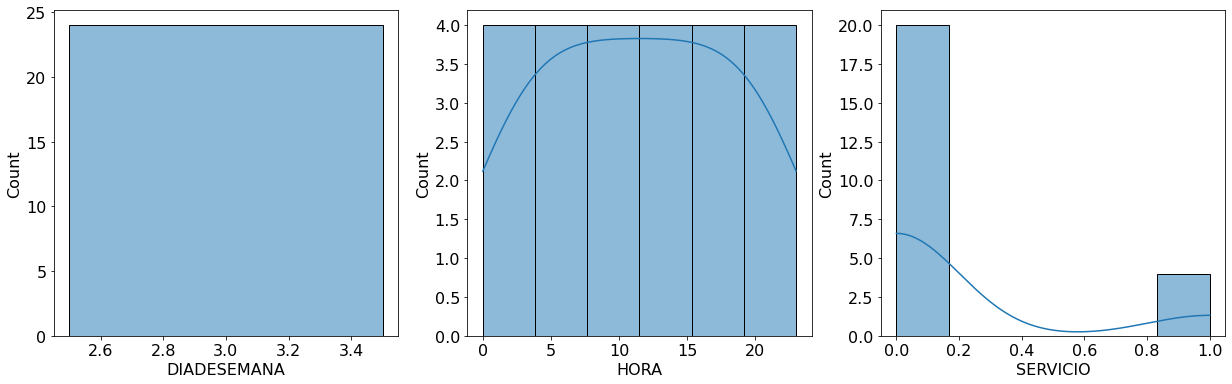

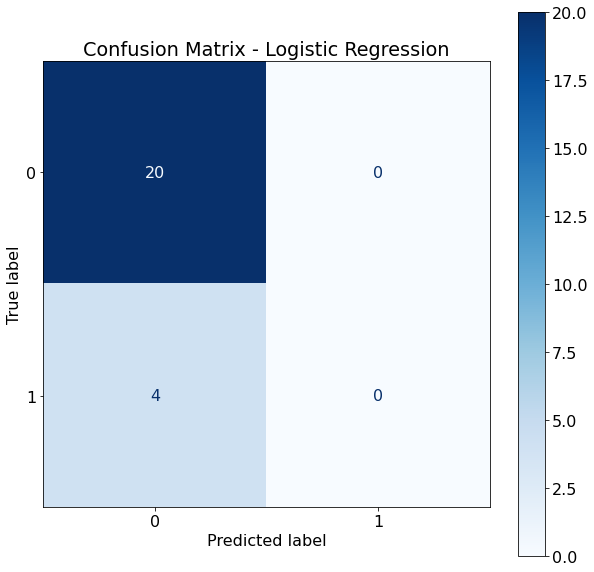

In [289]:
#Se recorre los teléfonos para entrenar el modelo a cada usuario
phone_array = data_phone[data_phone["TELEFONOORIGEN"]=="3115590650"].to_numpy()[:10]
# 

DATE_START_TRAINIG = pd.to_datetime("2022-04-27", format=FORMAT_DATE)
for data_row in phone_array:
    print("Processing...",data_row[0])
    
    date_finish_test = DATE_START_TRAINIG + timedelta(days=1)
    days_of_test = date_finish_test.date() - DATE_START_TRAINIG.date()
    print("From: ",DATE_START_TRAINIG, ", To: ",date_finish_test, ", Remaning: ",days_of_test)
    array_date_of_week = []
    for i in range(days_of_test.days):
        date_training = DATE_START_TRAINIG + timedelta(days=i)
        date_last_training = date_training - timedelta(weeks=NUM_OF_WEEK)
        print("------------------------------------------")
        #print("date trainig: ",date_training, " - last trainig: ", date_last_training, " remaninig:", date_training.date() - date_last_training.date())

        
        #Se filtran los datos para el número de teléfono
        data_user = data[data["TELEFONOORIGEN"]==data_row[0]].copy()
        
        df_train = data_user[ (pd.to_datetime(data_user['FECHA'], format=FORMAT_DATE) < date_training) & (pd.to_datetime(data_user['FECHA'], format=FORMAT_DATE) > date_last_training) ]
        df_test = data_user[(pd.to_datetime(data_user['FECHA'], format=FORMAT_DATE) == date_training) & (data_user['DIADESEMANA'] == date_training.isoweekday()) ]
        
        #df_train = data_user.groupby('TELEFONOORIGEN').filter(lambda x: x['TELEFONOORIGEN'].count() > 1)
        
        print("Real using")
        print( df_test.to_numpy() )
        print("Model prediction")
        
        if len(df_train) > 0:

            train = preparingDataService(df_train, date_last_training, date_training, data_row[0])
            test = preparingDataService(df_test, date_training, date_training, data_row[0])

            #print("test head: ",test)
            
            '''
            service = train[train.SERVICIO == 1]
            not_service = train[train.SERVICIO == 0]

            plot.figure(figsize=(14, 8))
            plot.plot(service['DIADESEMANA'].values, service['HORA'].values, linestyle='', marker='o', color='royalblue', label='Service')
            plot.plot(not_service['DIADESEMANA'].values, not_service['HORA'].values, linestyle='', marker='x', color='r', label='Not Service')
            plot.title("Servicio results")
            plot.legend()
            plot.grid()
            plot.xlabel('Día de la semana')
            plot.ylabel('Hora')
            plot.show()
            '''
            train = train.loc[:,['DIADESEMANA','HORA','SERVICIO']]
            test = test.loc[:,['DIADESEMANA','HORA','SERVICIO']]

            
            #Se visualiza los datos por columnas
            import seaborn as sns
            fig, axes = plot.subplots(1, 3)
            fig.set_size_inches(21,6)
            for i, column in enumerate(test.columns):
                sns.histplot(test[column], kde=True, ax=axes[i])
            
            #print("train shape: ",train.shape)
            
            #std = StandardScaler()
            #data_train = pd.DataFrame(std.fit_transform(train), columns=train.columns)
            #print("train head: ",data_lineal.head())
            
            y_train = train.SERVICIO
            X_train = train.drop(labels='SERVICIO', axis=1)

            #std = StandardScaler()
            #data_test = pd.DataFrame(std.fit_transform(test), columns=test.columns)
            #print("test head: ",data_test.head())

            y_test = test.SERVICIO
            X_test = test.drop(labels='SERVICIO', axis=1)

            
            classifier = LogisticRegression(random_state = 0)
            classifier.fit(X_train, y_train)

            

            ypred = classifier.predict(X_test)
            conf_matrix = confusion_matrix(y_test, ypred)

            print("Predict:",ypred)
            
            print ("Confusion Matrix: \n", conf_matrix)

            
            plot.rcParams.update({'font.size': 16})
            fig, axes = plot.subplots(figsize=(10, 10))
            disp = ConfusionMatrixDisplay.from_estimator(classifier,
                                                        X_test,
                                                        y_test,
                                                        display_labels=classifier.classes_,
                                                        cmap=plot.cm.Blues,
                                                        ax=axes
                                                        )
            disp.ax_.set_title('Confusion Matrix - Logistic Regression')

            '''
            array_hours = []
            for hour in range(HOURS_OF_DAY):
                prob = calculateProbability(hour, date_training.isoweekday(), train)
                if (prob >= 0.1):
                    print("[",data_row[0],",",date_training.isoweekday(),",",hour,",",date_training,",",prob,"]")
                #array_hours.append( [date_predict.isoweekday(),hour,prob] )
            #array_date_of_week.append(array_hours)
            '''
            
        else:
            print("User doesn't have information")
        
    #print(array_date_of_week)

In [211]:
'''data.hist(bins=30, figsize=(14, 8), color="blue",alpha=0.5)
plot.show()'''

'data.hist(bins=30, figsize=(14, 8), color="blue",alpha=0.5)\nplot.show()'

# Probando con función probabilistica

In [212]:
'''df_mp = df.copy()
df_mp = df_mp[df_mp["TELEFONOORIGEN"]=="3115590650"]


#Se llenan los datos faltantes
df_mp = completeServices(df_mp)'''

'df_mp = df.copy()\ndf_mp = df_mp[df_mp["TELEFONOORIGEN"]=="3115590650"]\n\n\n#Se llenan los datos faltantes\ndf_mp = completeServices(df_mp)'

In [213]:
#df_mp.head(5)

In [214]:
#df_mp.loc[:,['TELEFONOORIGEN']].value_counts()

Se muestra la probabilidad de un usuario con los datos de entrenamiento

In [215]:
'''def calculateProbabilisticModel(dataFrame):
  array_date_of_week = []
  for day in range(DAYS_OF_WEEK):
    array_hours = []
    for hour in range(HOURS_OF_DAY):
      array_hours.append( calculateProbability(hour, day+1, dataFrame))
    array_date_of_week.append(array_hours)
  return pd.DataFrame(np.array(array_date_of_week),
                    columns=[h for h in range(HOURS_OF_DAY)], index=["1-Monday","2-Tuesday","3-Wednesday","4-Thursday","5-Friday","6-Saturday","7-Sunday"],).transpose()'''

'def calculateProbabilisticModel(dataFrame):\n  array_date_of_week = []\n  for day in range(DAYS_OF_WEEK):\n    array_hours = []\n    for hour in range(HOURS_OF_DAY):\n      array_hours.append( calculateProbability(hour, day+1, dataFrame))\n    array_date_of_week.append(array_hours)\n  return pd.DataFrame(np.array(array_date_of_week),\n                    columns=[h for h in range(HOURS_OF_DAY)], index=["1-Monday","2-Tuesday","3-Wednesday","4-Thursday","5-Friday","6-Saturday","7-Sunday"],).transpose()'

Se prueba con los datos de entrenamiento

In [216]:
#calculateProbabilisticModel(train)

Se valida con los datos de pruebas

In [217]:
#calculateProbabilisticModel(test)

# Exploración inicial

In [218]:
'''df_reg = df_mp.copy()
df_reg = df_reg.drop(columns=['TELEFONOORIGEN','FECHA'])
fig, axes = plot.subplots(1, 3)
fig.set_size_inches(21,6)
for i, column in enumerate(df_reg.columns):
  sns.histplot(df_reg[column], kde=True, ax=axes[i])'''

"df_reg = df_mp.copy()\ndf_reg = df_reg.drop(columns=['TELEFONOORIGEN','FECHA'])\nfig, axes = plot.subplots(1, 3)\nfig.set_size_inches(21,6)\nfor i, column in enumerate(df_reg.columns):\n  sns.histplot(df_reg[column], kde=True, ax=axes[i])"

Se genera un diagrama de dispersión

In [219]:
'''served = df_reg[df_reg.SERVICIO == 1]
not_served = df_reg[df_reg.SERVICIO == 0]

plot.figure(figsize=(14, 8))
plot.plot(served['DIADESEMANA'].values, served['HORA'].values, linestyle='', marker='o', color='royalblue', label='Served')
plot.plot(not_served['DIADESEMANA'].values, not_served['HORA'].values, linestyle='', marker='x', color='r', label='Not Served')
plot.title("Services results")
plot.legend()
plot.grid()
plot.xlabel('Dia de la semana')
plot.ylabel('Hora')
plot.show()'''

'served = df_reg[df_reg.SERVICIO == 1]\nnot_served = df_reg[df_reg.SERVICIO == 0]\n\nplot.figure(figsize=(14, 8))\nplot.plot(served[\'DIADESEMANA\'].values, served[\'HORA\'].values, linestyle=\'\', marker=\'o\', color=\'royalblue\', label=\'Served\')\nplot.plot(not_served[\'DIADESEMANA\'].values, not_served[\'HORA\'].values, linestyle=\'\', marker=\'x\', color=\'r\', label=\'Not Served\')\nplot.title("Services results")\nplot.legend()\nplot.grid()\nplot.xlabel(\'Dia de la semana\')\nplot.ylabel(\'Hora\')\nplot.show()'

In [220]:
#df_reg[['DIADESEMANA','HORA']].boxplot(figsize=(14,9))

Generando datos de prueba y entrenamiento

In [221]:
#CONJUNTO DE DATOS DE PRUEBA (20%)
'''
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_reg, test_size=0.2, random_state=3, shuffle=True)
print(train)'''

'\nfrom sklearn.model_selection import train_test_split\ntrain, test = train_test_split(df_reg, test_size=0.2, random_state=3, shuffle=True)\nprint(train)'

In [222]:
#datos de entrenamiento
#train.shape

In [223]:
#Matriz de Dispersion con MatPlotLib
#pd.plotting.scatter_matrix(train.loc[:,['DIADESEMANA','HORA','SERVICIO']], figsize=(14,10), alpha=0.8)
#plot.show()

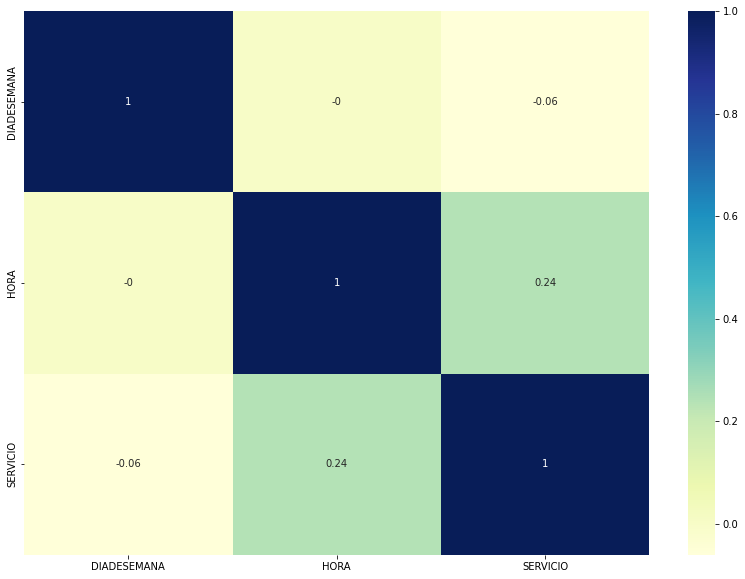

In [224]:
correlation_matrix = train.corr().round(2) 
fig, heat = plot.subplots(figsize = (14,10))
heat = sns.heatmap(data=correlation_matrix, annot=True, cmap="YlGnBu")
plot.show()

In [225]:
#train.corr().SERVICIO.to_frame()

# Generación del modelo

In [226]:
'''from sklearn.preprocessing import StandardScaler
std = StandardScaler()
data = pd.DataFrame(std.fit_transform(train), columns=train.columns)
data.head()'''

'from sklearn.preprocessing import StandardScaler\nstd = StandardScaler()\ndata = pd.DataFrame(std.fit_transform(train), columns=train.columns)\ndata.head()'

In [227]:
'''yrl = data.SERVICIO
features = ['HORA',	'DIADESEMANA']
Xrl = data[features]'''

"yrl = data.SERVICIO\nfeatures = ['HORA',\t'DIADESEMANA']\nXrl = data[features]"

##Evaluación de modelos##

ALGORITMO DE LOS KNN